In [ ]:
!pip install kaggle

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split

# Download and unzip the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip face-mask-dataset.zip -d face-mask-dataset

Streaming output truncated to the last 5000 lines.
  inflating: face-mask-dataset/data/with_mask/with_mask_3297.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3298.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3299.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_33.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_330.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3300.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3301.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3302.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3303.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3304.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3305.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3306.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3307.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3308.jpg  
  inflating: f

In [4]:
# Directory paths
base_dir = 'face-mask-dataset/data'
train_dir = os.path.join(base_dir)
validation_dir = os.path.join(base_dir)

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 #20% for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

from keras.layers import Dropout
from keras.optimizers import Adam

# Load VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer and custom learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [ ]:
!ls

face-mask-dataset  face-mask-dataset.zip  kaggle.json  sample_data


In [5]:
# Train the model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=validation_generator
)

# Save the trained model
model.save('face_mask_model_dropout.h5')

Epoch 1/7
 76/189 [===========>..................] - ETA: 22s - loss: 0.3901 - accuracy: 0.8257

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 58s 265ms/step - loss: 0.3010 - accuracy: 0.8739 - val_loss: 0.2528 - val_accuracy: 0.8921
Epoch 2/7
189/189 [==============================] - 47s 250ms/step - loss: 0.2195 - accuracy: 0.9098 - val_loss: 0.2555 - val_accuracy: 0.8854
Epoch 3/7
189/189 [==============================] - 45s 240ms/step - loss: 0.1810 - accuracy: 0.9317 - val_loss: 0.1969 - val_accuracy: 0.9146
Epoch 4/7
189/189 [==============================] - 47s 248ms/step - loss: 0.2000 - accuracy: 0.9204 - val_loss: 0.1807 - val_accuracy: 0.9185
Epoch 5/7
189/189 [==============================] - 45s 237ms/step - loss: 0.1710 - accuracy: 0.9355 - val_loss: 0.1769 - val_accuracy: 0.9232
Epoch 6/7
189/189 [==============================] - 47s 250ms/step - loss: 0.1720 - accuracy: 0.9293 - val_loss: 0.1718 - val_accuracy: 0.9238
Epoch 7/7
189/189 [==============================] - 48s 254ms/step - loss: 0.1636 - accuracy: 0.9343 - val_loss: 0.1789 - val_accuracy: 0.9185


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls

face-mask-dataset  face-mask-dataset.zip  face_mask_model_dropout.h5  mask.jpeg  sample_data


In [6]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")

48/48 [==============================] - 9s 186ms/step - loss: 0.1861 - accuracy: 0.9192
Test accuracy: 0.9192053079605103


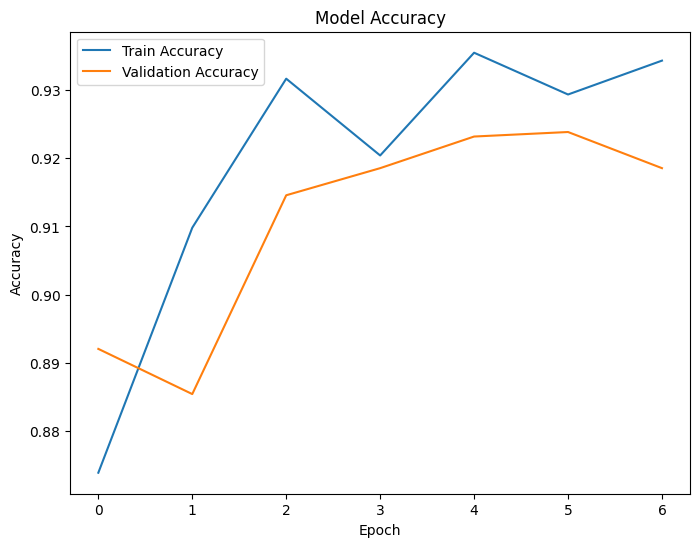

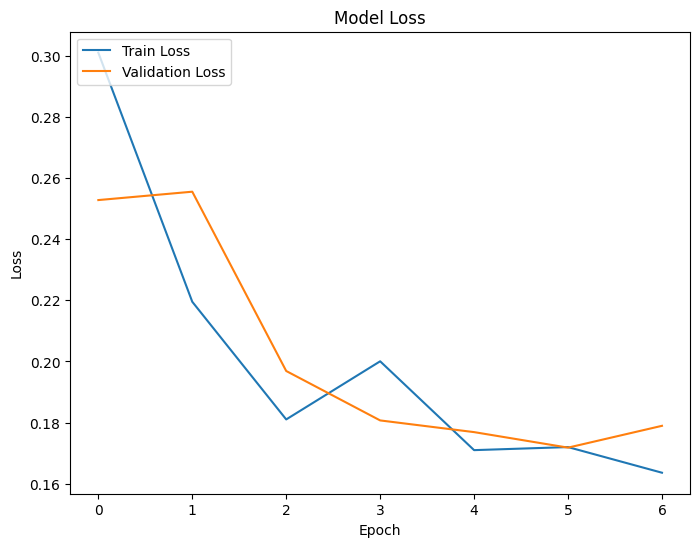

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step


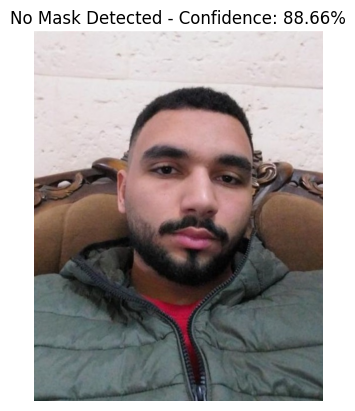

1/1 [==============================] - 0s 19ms/step


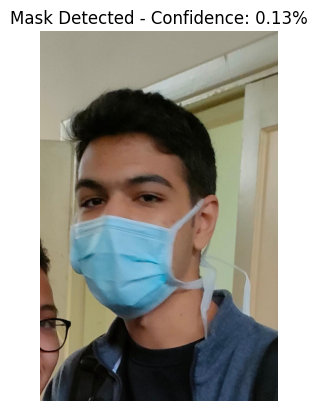

1/1 [==============================] - 0s 18ms/step


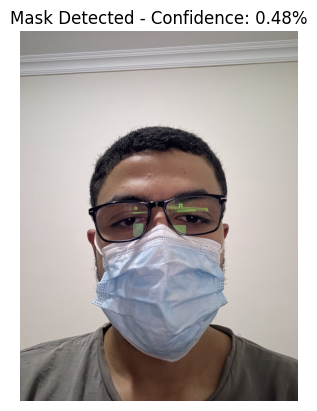

1/1 [==============================] - 0s 18ms/step


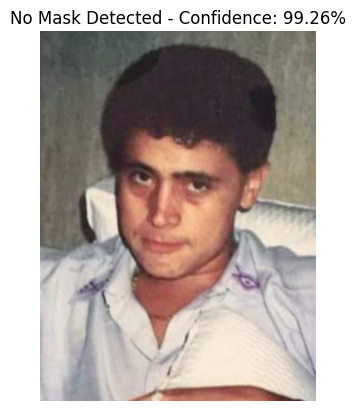

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained model
model = load_model('face_mask_model_dropout.h5')

# Function to preprocess the input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

# Function to make predictions
def predict_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    confidence_percentage = prediction[0][0] * 100
    if prediction < 0.5:
        label = "Mask Detected"
    else:
        label = "No Mask Detected"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'{label} - Confidence: {confidence_percentage:.2f}%')
    plt.show()

# Example usage:
image_paths = ["/content/disha.jpeg", "/content/guymask.jpeg", "/content/amrmask.jpg", "/content/john.jpeg"]

for image_path in image_paths:
    predict_image(image_path)


Found 7553 images belonging to 2 classes.
 75/237 [========>.....................] - ETA: 14s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


237/237 [==============================] - 18s 73ms/step
Accuracy: 0.9575
Precision: 0.9819
Recall: 0.9334
F1 Score: 0.9570


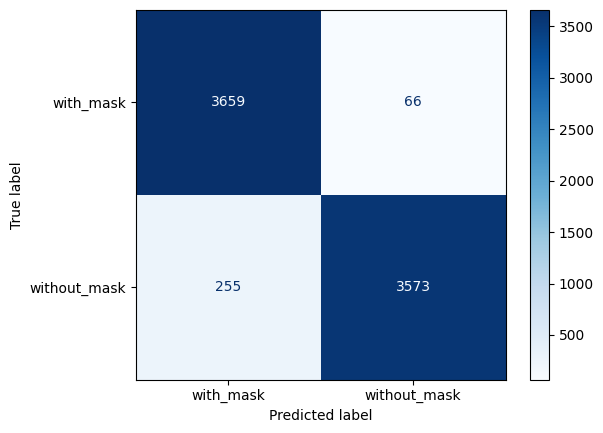

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model = tf.keras.models.load_model('face_mask_model_dropout.h5')

# Create a data generator for the validation set
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Get the ground truth labels
y_true = validation_generator.classes

# Get the predicted labels
predictions = model.predict(validation_generator, verbose=1)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

# Ensure the lengths match
y_pred = y_pred[:len(y_true)]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Compute and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()
